In [5]:
import simsz.get_dm_halo as get_dm_halo
import simsz.utils as utils
import make_sz_cluster
import simsz.read_yaml as read_yaml
import simsz.load_vars as load_vars

import time
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import h5py

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

What this notebook currently does: 
- Reads in data from the sim run yaml
- Loads cosmology
- Generates and saves a flat redshift and Mvir distribution as a .txt file
- Loads an existing redshift and Mvir distribution from a .txt file

What this notebook could do, but currently doesn't:
- Generate/use M200 rather than convert from Mvir
- Save m, z dist as .h
- Generates a realistic z, M500 distribution from a given cosmology 

What the modules could be improved to do:
- Streamline the generation of z,M500 distributions by creating a function with options
- Save the z, M500 distribution at the function level in GenerateHalo.py

Problems to be addressed:
- Profile is oddly steep and needs to be checked with Battaglia 2012 realistic z,M, params

In [6]:
ref=read_yaml.YAMLOperator('./simsz/Settings/inputdata.yaml').parse_yaml() #Read in the .yaml for this simulation run 

In [7]:
(survey,survey_freq,beam_size,noise_level,image_size,pixel_scale)=load_vars.load_vars().make_dict(ref) #Make a dictionary from the .yaml

In [8]:
(cosmo,sigma8,ns)=load_vars.load_vars().flatLCDM(ref) #Make cosmology from yaml input parameters 

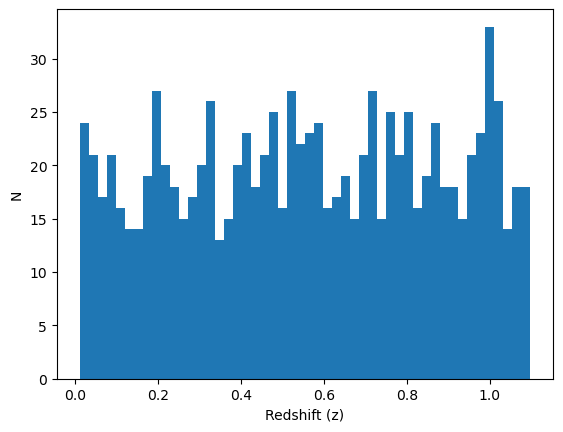

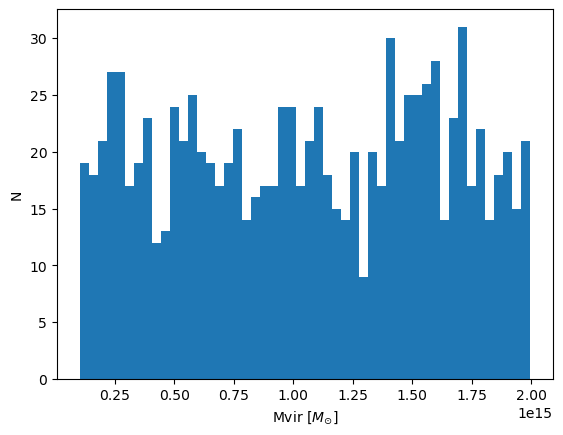

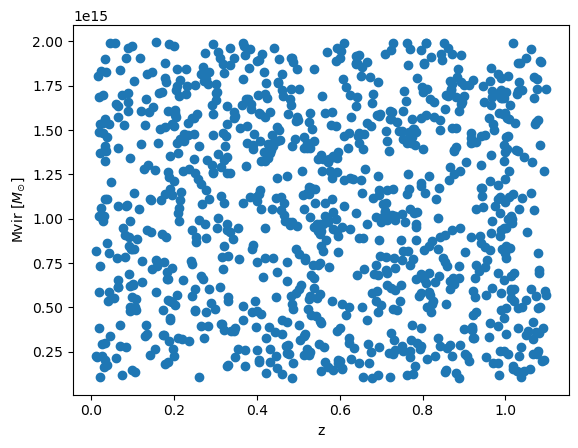

In [9]:
#Generate a new flat z, Mvir distribution and save to file: 
halo=get_dm_halo.GenerateHalo() #Load in get_dm_halo class
szcluster=make_sz_cluster.GenerateCluster() #Load in make_sz_cluster class
nsources=1000 #Number of halos to generate
zdist,mdist=halo.flatdist_halo(0.01,1.1,1e14,2e15,nsources) #Generate a flat z, Mvir distribution for sims

plt.hist(zdist,bins=50) #Show the z distribution 
plt.ylabel('N'),plt.xlabel('Redshift (z)')
plt.show()
plt.hist(mdist,bins=50) #Show the M500 distribution 
plt.ylabel('N'),plt.xlabel(r'Mvir [$M_{\odot}$]')
plt.show()
plt.plot(zdist,mdist,'o') #Show the z, M500 scatterplot
plt.xlabel('z'),plt.ylabel(r'Mvir [$M_{\odot}$]')
plt.show()

sourceid=int(time.time()) #Create an initial ctime for the halo ID list to save catalog
idlist=[sourceid+x for x in range(len(zdist))] #Create the halo ID list for catalog

np.savetxt('flatmassdist.csv',np.array([zdist,mdist,idlist]).T,delimiter=',') #Save this array to txt

In [10]:
#Load an existing z, M array from txt file
d=np.loadtxt('flatmassdist.csv',delimiter=',') 
zdist=d[:,0]
mdist=d[:,1]
idlist=d[:,2]

In [11]:
r=np.linspace(0.01,10,10000) #arcmin
r=utils.arcmin_to_Mpc(r,0.5,cosmo)

In [12]:
z=0.48
Mvir=2.21e14 #solar masses

In [13]:
(M200,R200,c200)=halo.vir_to_200_colossus(cosmo,sigma8,ns,Mvir,z) #Convert virial mass to M200 and get R200, concentration from Colossus

In [14]:
P200 = szcluster.P200_Battaglia2012(cosmo,z,M200,R200) #P200 from Battaglia et al. 2012

In [15]:
P0=szcluster.param_Battaglia2012(18.1,0.154,-0.758,M200,z) #Parameter computation from Table 1 Battaglia et al. 2012
xc=szcluster.param_Battaglia2012(0.497,-0.00865,0.731,M200,z)
beta=szcluster.param_Battaglia2012(4.35,0.0393,0.415,M200,z)

In [16]:
Pth=szcluster.Pth_Battaglia2012(r,R200,-0.3,1.0,beta,xc,P0) #Output Battaglia 2012 pressure profile

In [17]:
Pth_rescaled=(Pth)*(r/R200)**3.

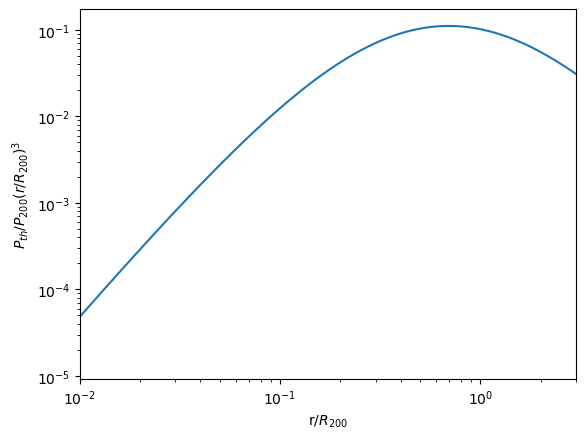

In [18]:
plt.plot(r/R200,Pth_rescaled) #Plot Battaglia 2012 pressure profile
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P_{th}/P_{200}(r/R_{200})^3$')
plt.xlabel('r/$R_{200}$')
plt.xlim(.010,3)
plt.show()

In [19]:
y = szcluster.epp_to_y(szcluster.Pth_Battaglia2012, r, R200=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200=P200)

In [20]:
y[0] #print central y value

2.0780684899743718e-05

In [21]:
fSZ=szcluster.f_sz(30,cosmo.Tcmb0) #get f_SZ for observation frequency of 30 GHz
dT=cosmo.Tcmb0*y[0]*fSZ #get dT from y0 using f_SZ
dT=dT.to(u.uK) #Convert to uK
print(dT)

-110.632216673186 uK


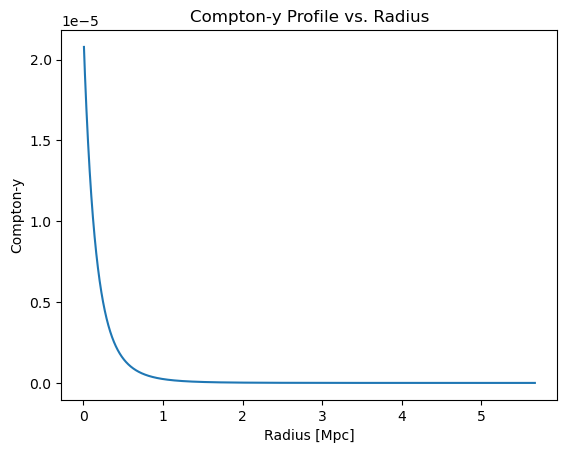

In [22]:
plt.plot(r, y)
plt.xlabel('Radius [Mpc]')
plt.ylabel('Compton-y')
plt.title('Compton-y Profile vs. Radius')

plt.show()

max:  2.1512691818266286e-05


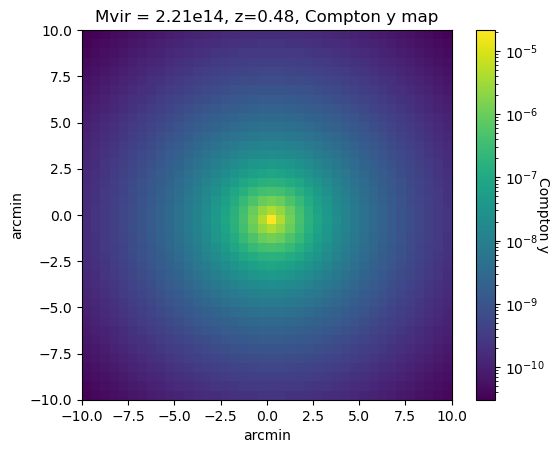

In [23]:
width = 10
pix_size = 0.5
y_map = szcluster.make_y_submap(szcluster.Pth_Battaglia2012, z, cosmo, width, pix_size, R200=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200=P200)
im = plt.imshow(y_map, norm=LogNorm())
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, Compton y map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('Compton y', rotation=270)
print('max: ', y_map.max())

max:  114.52927533159712 uK


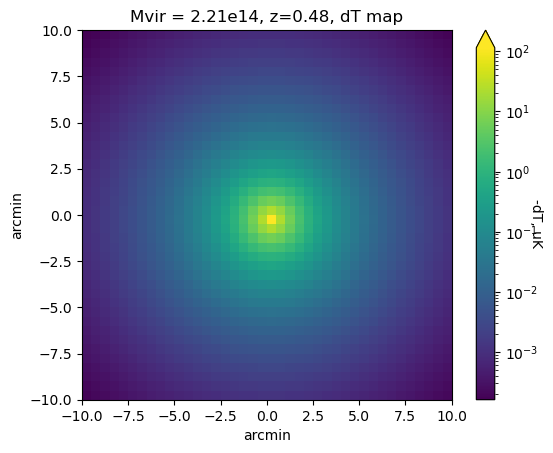

In [24]:
dT_map = (y_map * cosmo.Tcmb0 * -fSZ).to(u.uK)
im = plt.imshow(dT_map, norm=LogNorm())
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, dT map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
print("max: ", dT_map.max())

In [3]:
f = h5py.File('sz_map.hdf5', 'a')

In [25]:
# Data to be stored:
data = {
'M200': M200,
'redshift_z': z,
'concentration': c200,
'ID': 0,
'temperature_submap': dT_map,
'noise_submap' : np.zeros((10,10)),
'y_central' : y_map[width][width]
}
print(data)


{'M200': 194038855760143.56, 'redshift_z': 0.48, 'concentration': 3.7676041826225375, 'ID': 0, 'temperature_submap': <Quantity [[0.00016077, 0.00018288, 0.0002079 , ..., 0.0002361 ,
            0.0002079 , 0.00018288],
           [0.00018288, 0.00020938, 0.00023966, ..., 0.00027412,
            0.00023966, 0.00020938],
           [0.0002079 , 0.00023966, 0.00027629, ..., 0.00031841,
            0.00027629, 0.00023966],
           ...,
           [0.0002361 , 0.00027412, 0.00031841, ..., 0.0003699 ,
            0.00031841, 0.00027412],
           [0.0002079 , 0.00023966, 0.00027629, ..., 0.00031841,
            0.00027629, 0.00023966],
           [0.00018288, 0.00020938, 0.00023966, ..., 0.00027412,
            0.00023966, 0.00020938]] uK>, 'noise_submap': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.

In [59]:
f.create_dataset("sim_1/temp_map", data=dT_map)
f.create_dataset("sim_1/noise_map", data=data["noise_submap"])
f["sim_1"].attrs["M200"] = M200
f["sim_1"].attrs["ID"] = 0
f["sim_1"].attrs["Redshift"] = z
f["sim_1"].attrs["concentration"] = c200
f["sim_1"].attrs["y_central"] = y_map[width][width] #Should this be y_map.max() instead?
f["sim_1/temp_map"].attrs["unit"] = 'uK'

ValueError: Invalid location identifier (invalid location identifier)

In [58]:
f.close()

In [38]:
f["temp_map"].attrs["unit"]

'uK'

In [52]:
for ds in f:
    print(ds)
    for name in f[ds]:
        print(name)

sim_1
noise_map
temp_map


In [57]:
print(set(f["sim_1"].attrs.items()))

{('Redshift', 0.48), ('M200', 194038855760143.56), ('concentration', 3.7676041826225375), ('ID', 0), ('y_central', 9.60691625540979e-10)}
